In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout

In [30]:
#!pip install tensorflow

In [31]:
# Load the Excel file
file_path = r"C:\Users\bs231247\OneDrive - Queen Mary, University of London\Desktop\Bloomberg\Research\Magnificient_7_same_base_data.xlsx"
excel_data = pd.ExcelFile(file_path)

In [32]:
excel_data

In [33]:
def process_company_data(sheet_name, data, time_steps, for_periods):
    '''
    task in this section:
    Process the data for a single company( one after the another).

    :param sheet_name: Name of the sheet (company) to process
    :param data: DataFrame with data for the company
    :param time_steps: number of input time steps
    :param for_periods: number of output time steps

    :returns(output): Trained models and their predictions
    '''
    # Prepare the data
    data = data.replace('#N/A N/A', 0)  # Replace '#N/A N/A' with 0
    data.fillna(0, inplace=True)  # Fill remaining NaN values with 0
    data['Dates'] = pd.to_datetime(data['Dates'], format='%d/%m/%Y')
    data.set_index('Dates', inplace=True)
    
    # Extract relevant columns
    data = data[['PX_LAST']]  # You can adjust which columns to use

    # Plot the closing prices
    sns.set(rc={'figure.figsize': (15, 9)})
    data['PX_LAST'].plot(grid=True)
    plt.title(f'{sheet_name} - PX_LAST', color='black', fontsize=20)
    plt.xlabel('Year', color='black', fontsize=15)
    plt.ylabel('Stock Price', color='black', fontsize=15)
    plt.show()

    # Prepare training and test data
    X_train, y_train, X_test, sc = ts_train_test(data, time_steps, for_periods)

    # Define and train RNN model
    my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test, sc)
    
    # Define and train LSTM model
    my_lstm_model, lstm_predictions = LSTM_model(X_train, y_train, X_test, sc)
    
    # Define and train GRU model
    my_gru_model, gru_predictions = GRU_model(X_train, y_train, X_test, sc)
    
    # Extract actual values for the period
    actual_values = data['PX_LAST'].loc['2017':].values[:len(rnn_predictions)]

    # Plot the results
    title_txt = f'{sheet_name} - RNN Model Predictions'
    actual_pred_plot(actual_values, rnn_predictions, title_txt)
    
    title_txt = f'{sheet_name} - LSTM Model Predictions'
    actual_pred_plot(actual_values, lstm_predictions, title_txt)
    
    title_txt = f'{sheet_name} - GRU Model Predictions'
    actual_pred_plot(actual_values, gru_predictions, title_txt)
    
    # Compute and print RMSE for each model
    rmse_rnn = np.sqrt(mean_squared_error(actual_values, rnn_predictions[:, 0]))
    rmse_lstm = np.sqrt(mean_squared_error(actual_values, lstm_predictions[:, 0]))
    rmse_gru = np.sqrt(mean_squared_error(actual_values, gru_predictions[:, 0]))

    print(f'{sheet_name} - RNN RMSE: {rmse_rnn:.4f}')
    print(f'{sheet_name} - LSTM RMSE: {rmse_lstm:.4f}')
    print(f'{sheet_name} - GRU RMSE: {rmse_gru:.4f}')


In [34]:
# Define a function to create training and test data
def ts_train_test(data, time_steps, for_periods):
    '''
    task in this section
    Create training and test sets, scale data

    :param data: DataFrame with dates and price data
    :param time_steps: number of input time steps
    :param for_periods: number of output time steps

    :returns(output): X_train, y_train: data from 2012-2019
              X_test:  data from 2017 onward
              sc: instantiated MinMaxScaler object fit to the training data
    '''
    ts_train = data['2012':'2019'].iloc[:, 0:1].values
    ts_test = data['2020':].iloc[:, 0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Feature scaling
    sc = MinMaxScaler(feature_range=(0, 1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # Create training data of samples and time steps
    X_train = []
    y_train = []
    for i in range(time_steps, ts_train_len - for_periods + 1):
        X_train.append(ts_train_scaled[i - time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i + for_periods, 0])

    # Convert X_train and y_train to numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshape X_train to 3-D array
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Prepare to create X_test
    inputs = pd.concat((data["PX_LAST"]['2012':'2019'], data["PX_LAST"]['2020':]), axis=0).values
    inputs = inputs[len(inputs) - len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    # Create X_test
    X_test = []
    for i in range(time_steps, len(ts_test) + time_steps - for_periods + 1):
        X_test.append(inputs[i - time_steps:i, 0])

    # Convert X_test to numpy array
    X_test = np.array(X_test)

    # Reshape X_test to 3-D
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, sc

In [35]:
# Define the RNN model
def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    task for thsi section:
    Create RNN model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: output features for training the model
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns(output): trained model and array of predicted prices to original scale
    '''
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2))  # The time step of the output is 2
    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')
    my_rnn_model.fit(X_train, y_train, epochs=200, batch_size=150, verbose=0)
    rnn_predictions = my_rnn_model.predict(X_test)
    rnn_predictions = sc.inverse_transform(rnn_predictions)
    return my_rnn_model, rnn_predictions


In [36]:
def actual_pred_plot(actuals, preds, title_txt):
    '''
    tasks for this section
    Plot the actual vs. predicted prices

    :param actuals: array of actual prices
    :param preds: array of predicted prices
    :param title_txt: Title of the plot
    '''
    # Create dataframe containing actual and predicted prices
    actual_dates = pd.date_range(start='2020-01-01', periods=len(preds), freq='B')
    actual_pred = pd.DataFrame({
        'Actual': actuals,
        'Prediction': preds[:, 0]
    }, index=actual_dates)

    # Calculate mean squared error
    mse = mean_squared_error(actuals, preds[:, 0])
    rmse = np.sqrt(mse)
    print(f"RMSE score: {rmse:.4f}")

    # Plot actual vs predicted prices
    sns.set(rc={'figure.figsize': (15, 9)})
    plt.figure()
    plt.plot(actual_pred.index, actual_pred['Actual'], label='Actual', color='blue')
    plt.plot(actual_pred.index, actual_pred['Prediction'], label='Prediction', color='red')
    plt.title(title_txt, color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('Stock Price', color='black', fontsize=15)
    plt.legend()
    plt.grid(True)
    plt.show()


In [37]:
# Define the LSTM model
def LSTM_model(X_train, y_train, X_test, sc):
    """
    tasks for this section
    Create LSTM model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: output features for training the model
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns(output): trained model and array of predicted prices to original scale
    """
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dropout(0.2))
    my_LSTM_model.add(Dense(units=2))
    my_LSTM_model.compile(optimizer='adam', loss='mean_squared_error')
    my_LSTM_model.fit(X_train, y_train, epochs=200, batch_size=150, verbose=0)
    LSTM_predictions = my_LSTM_model.predict(X_test)
    LSTM_predictions = sc.inverse_transform(LSTM_predictions)
    return my_LSTM_model, LSTM_predictions

In [38]:
# Define the GRU model
def GRU_model(X_train, y_train, X_test, sc):
    '''
    tasks for this section
    Create GRU model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: output features for training the model
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns(output): trained model and array of predicted prices to original scale
    '''
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units=2))
    my_GRU_model.compile(optimizer='adam', loss='mean_squared_error')
    my_GRU_model.fit(X_train, y_train, epochs=200, batch_size=150, verbose=0)
    GRU_predictions = my_GRU_model.predict(X_test)
    GRU_predictions = sc.inverse_transform(GRU_predictions)
    return my_GRU_model, GRU_predictions

Processing sheet: Apple


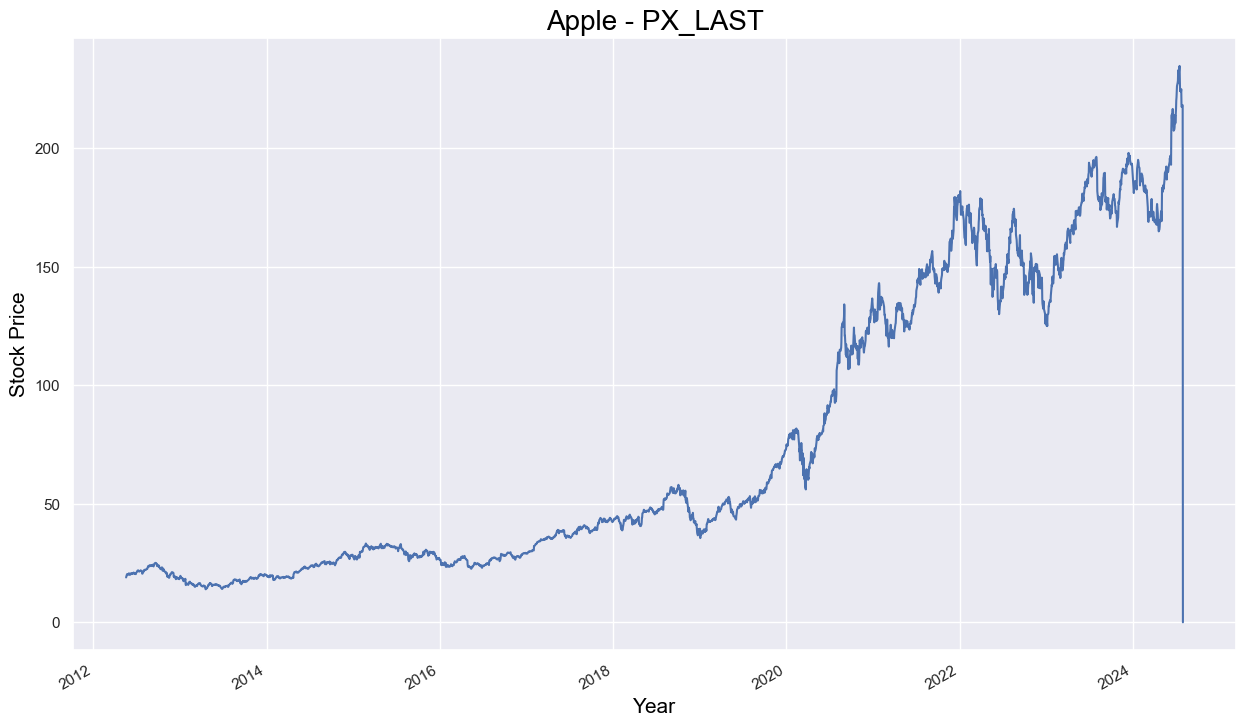

C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 
RMSE score: 66.6197


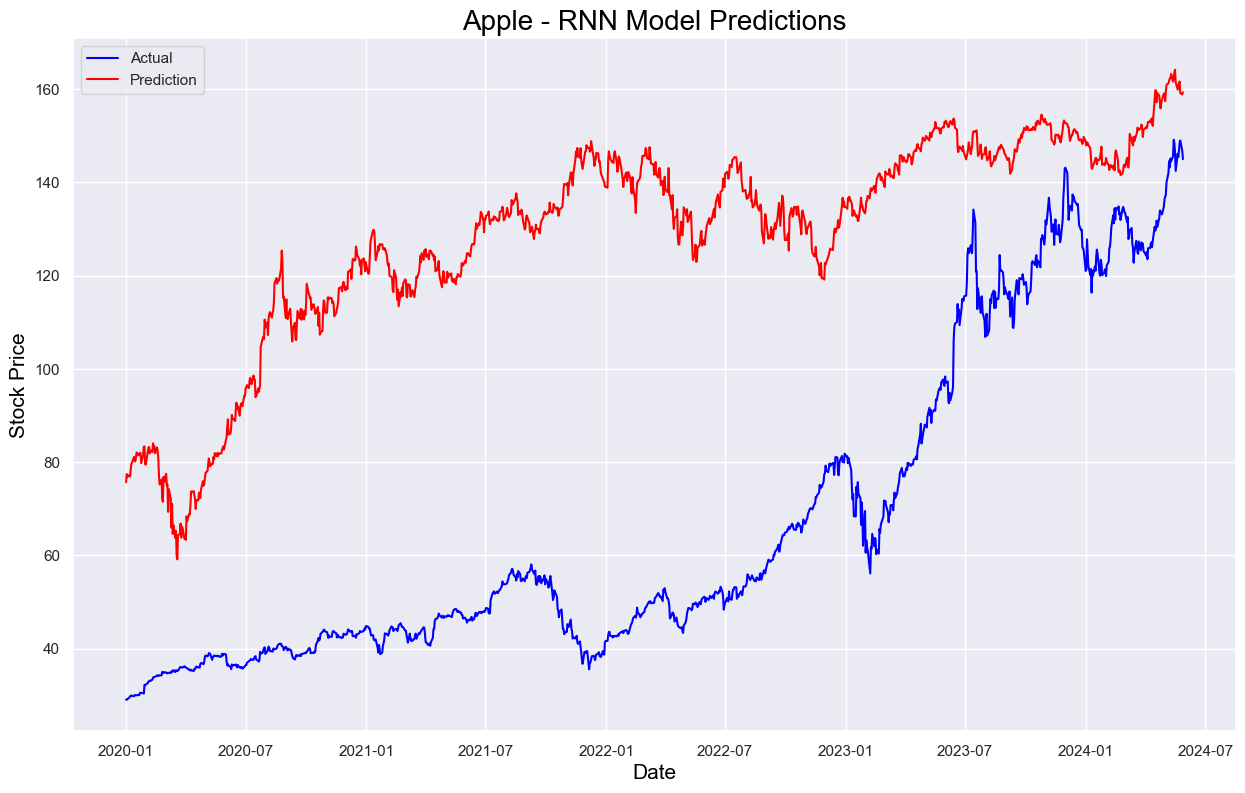

RMSE score: 68.4114


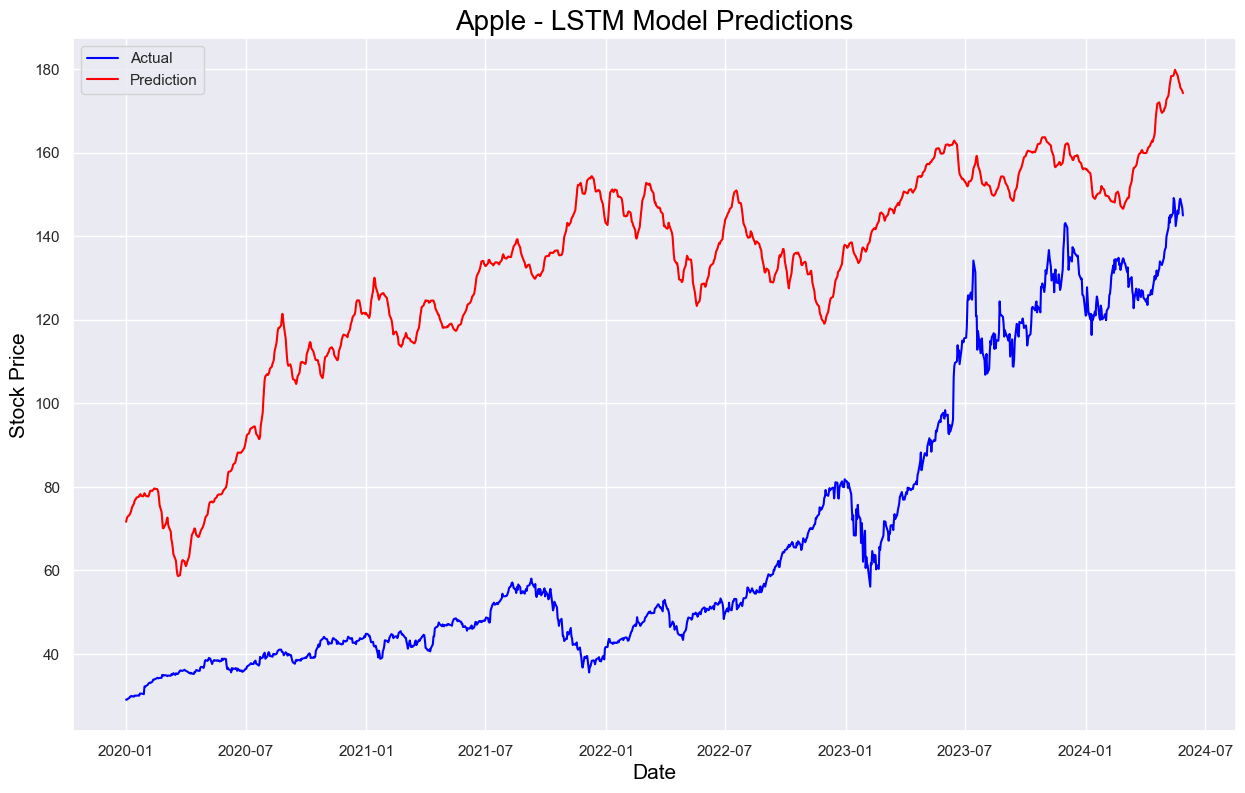

RMSE score: 84.4066


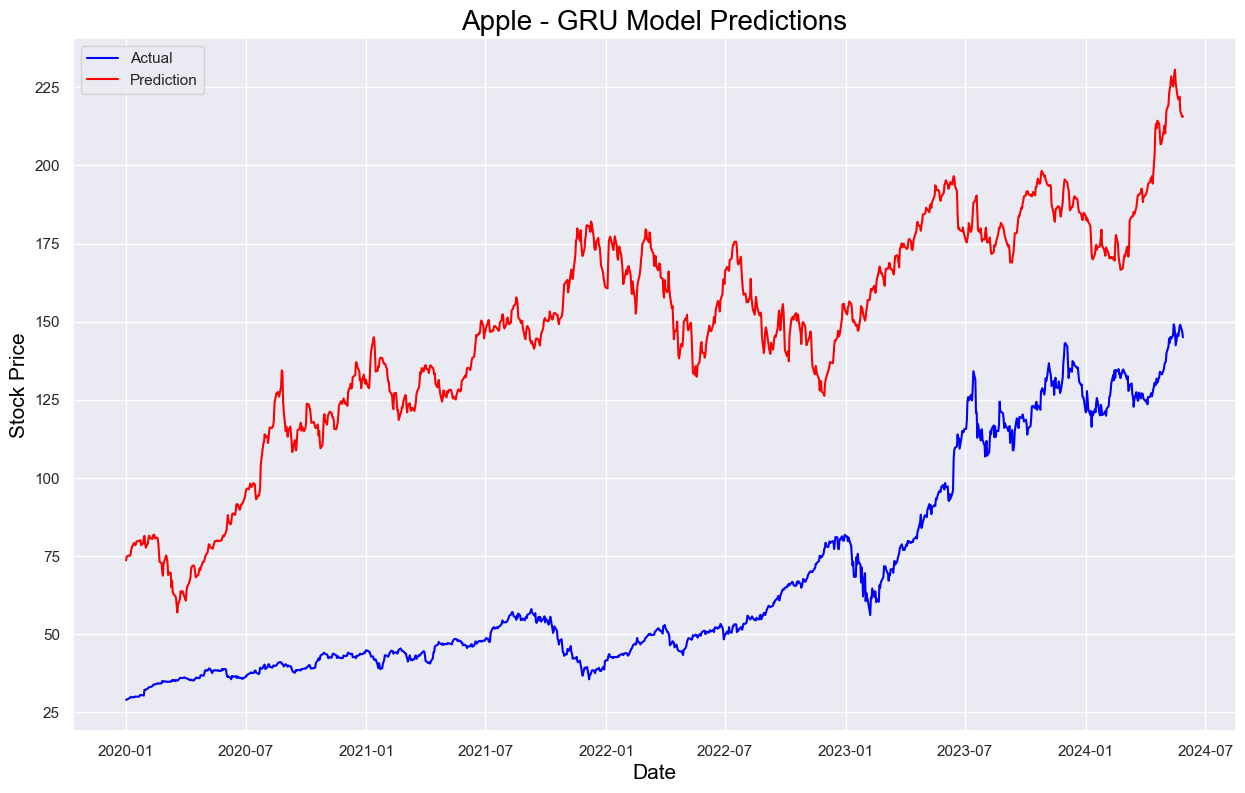

Apple - RNN RMSE: 66.6197
Apple - LSTM RMSE: 68.4114
Apple - GRU RMSE: 84.4066
Processing sheet: Microsoft


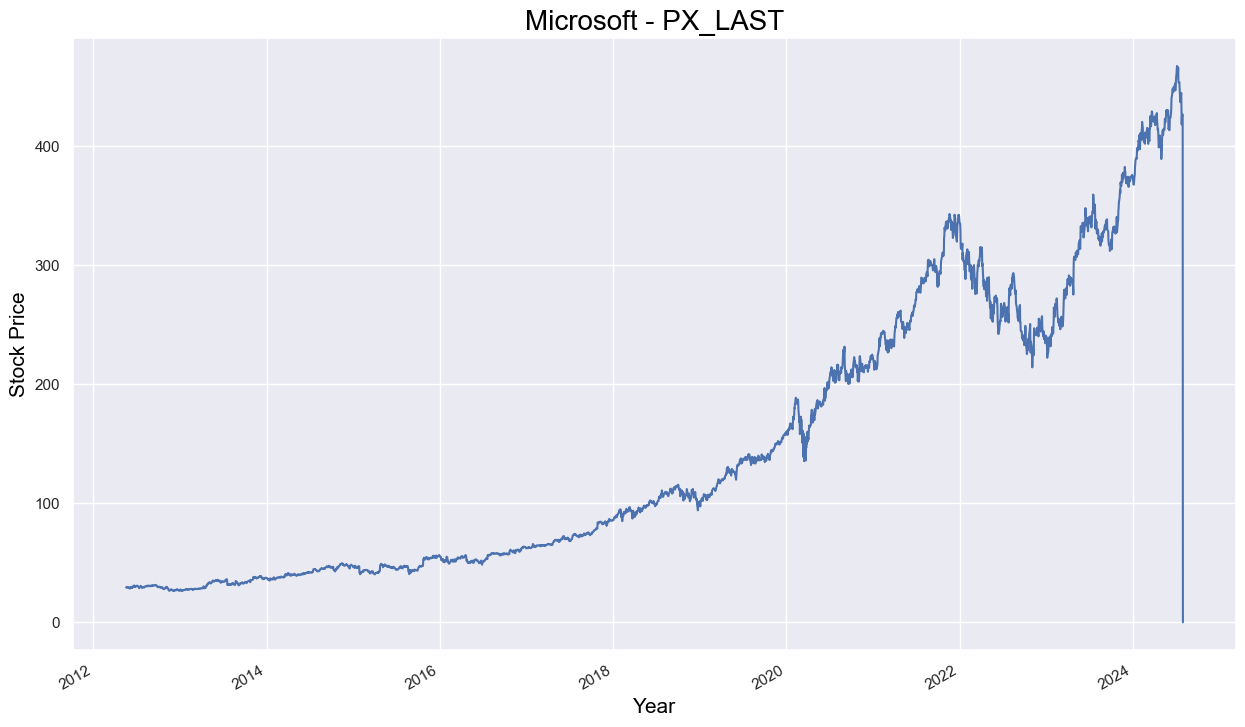

C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE score: 97.4897


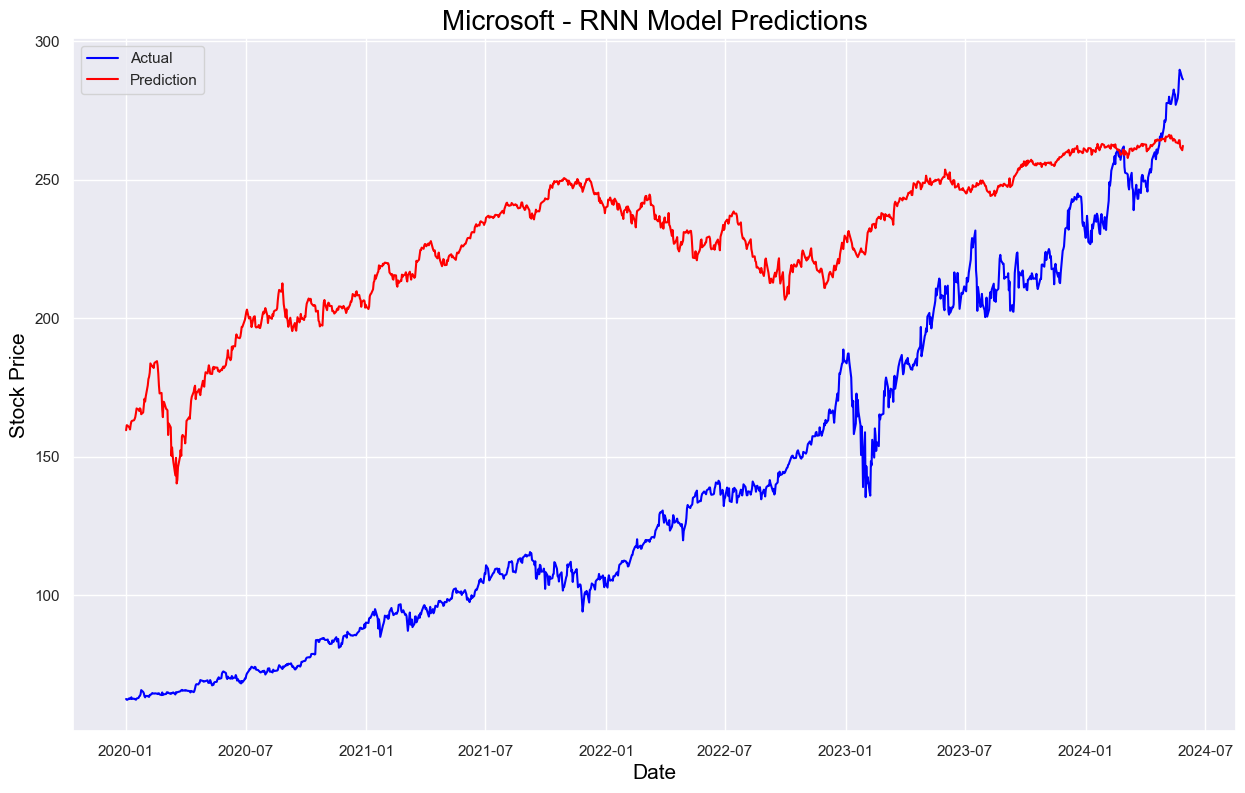

RMSE score: 120.4324


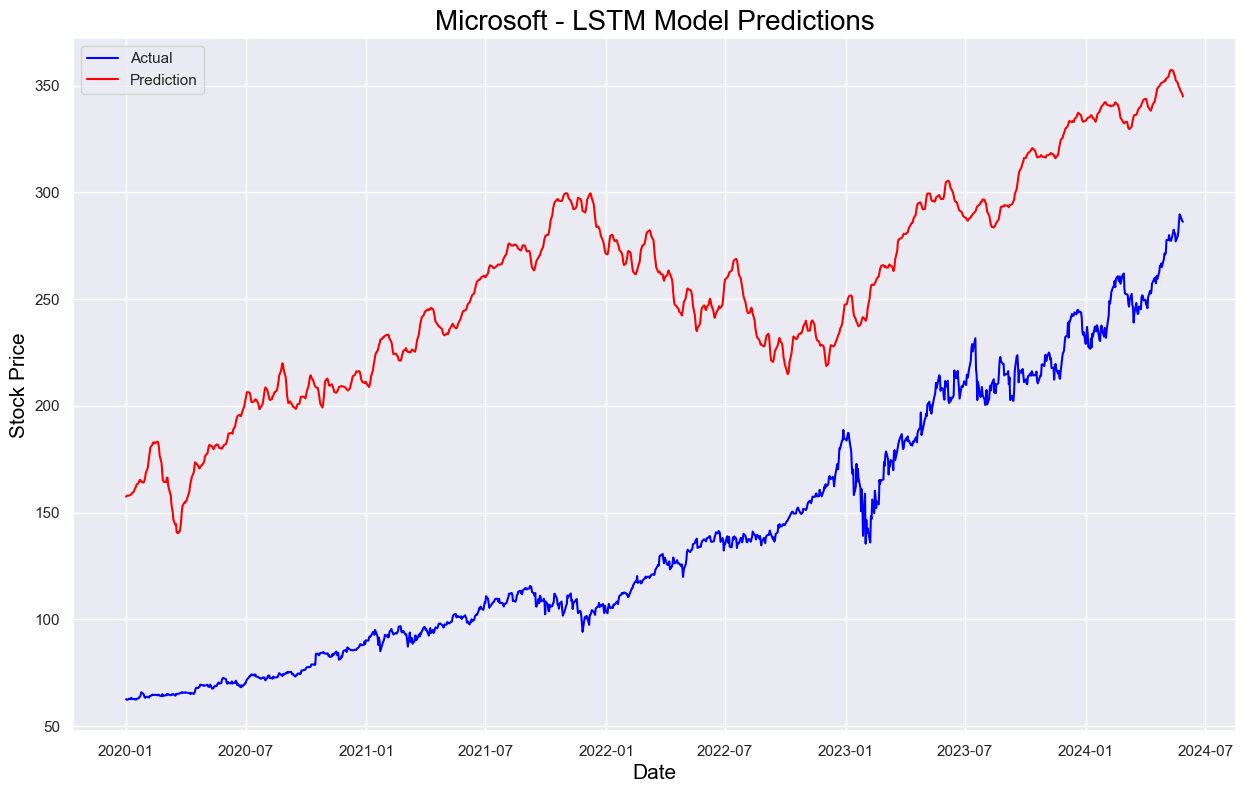

RMSE score: 134.8416


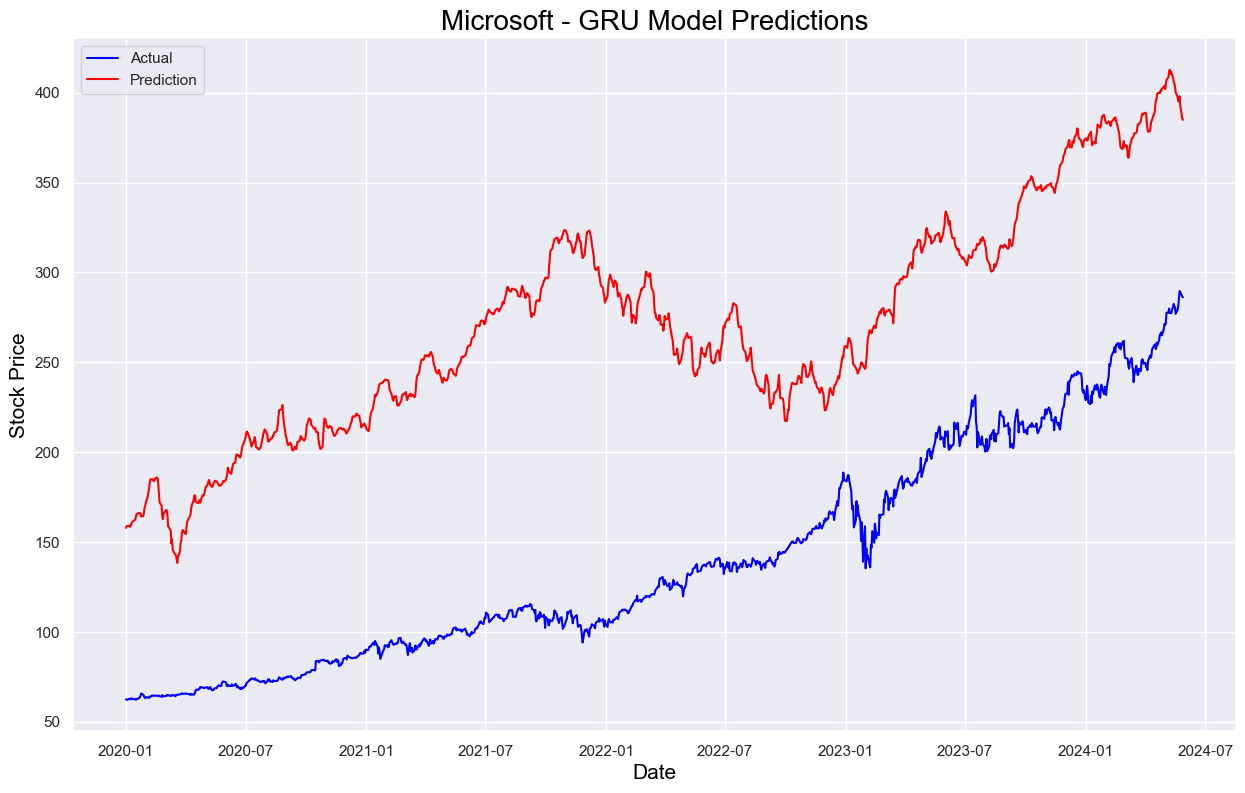

Microsoft - RNN RMSE: 97.4897
Microsoft - LSTM RMSE: 120.4324
Microsoft - GRU RMSE: 134.8416
Processing sheet: Nvidia


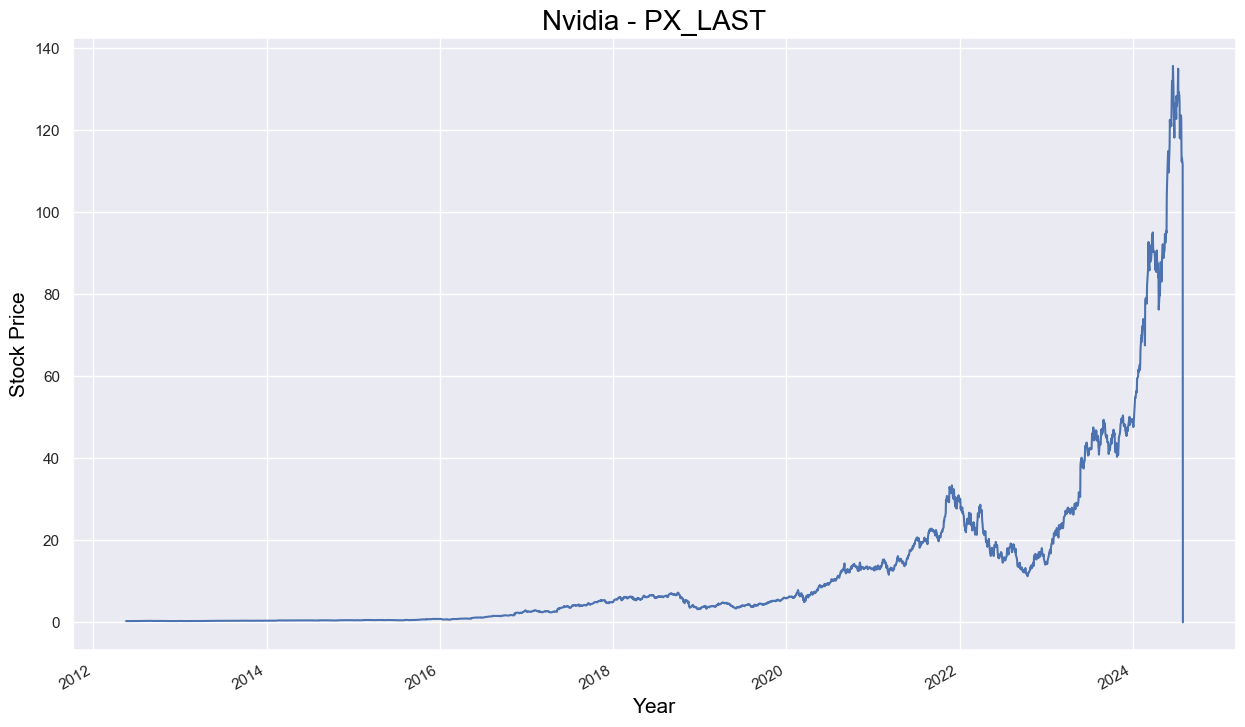

C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE score: 6.7455


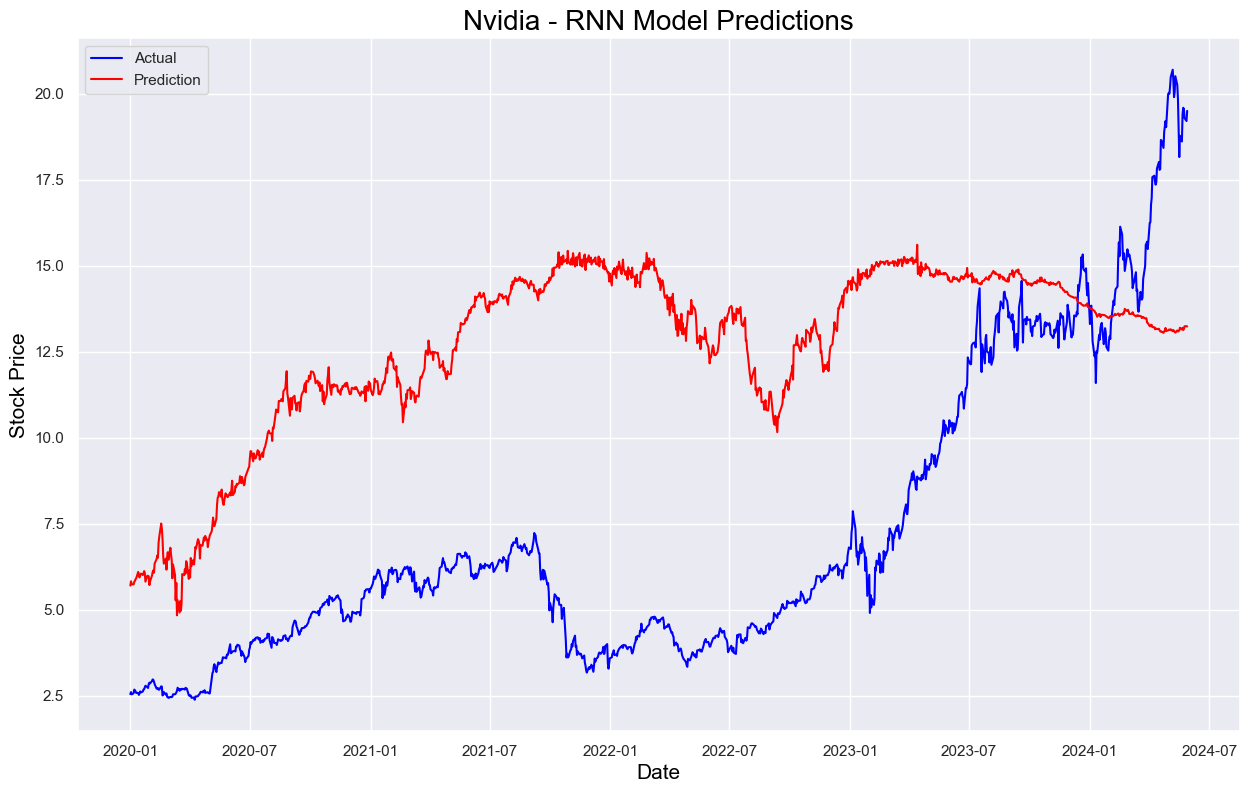

RMSE score: 10.3410


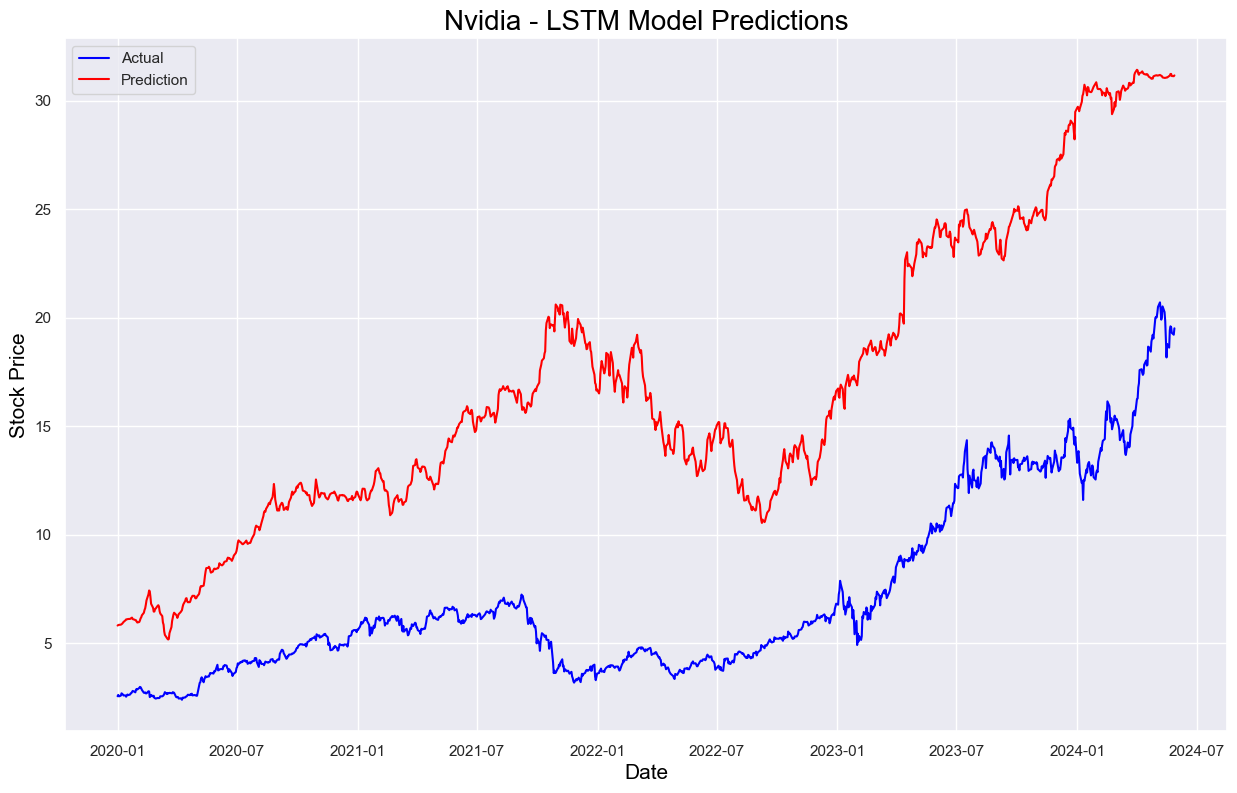

RMSE score: 17.1355


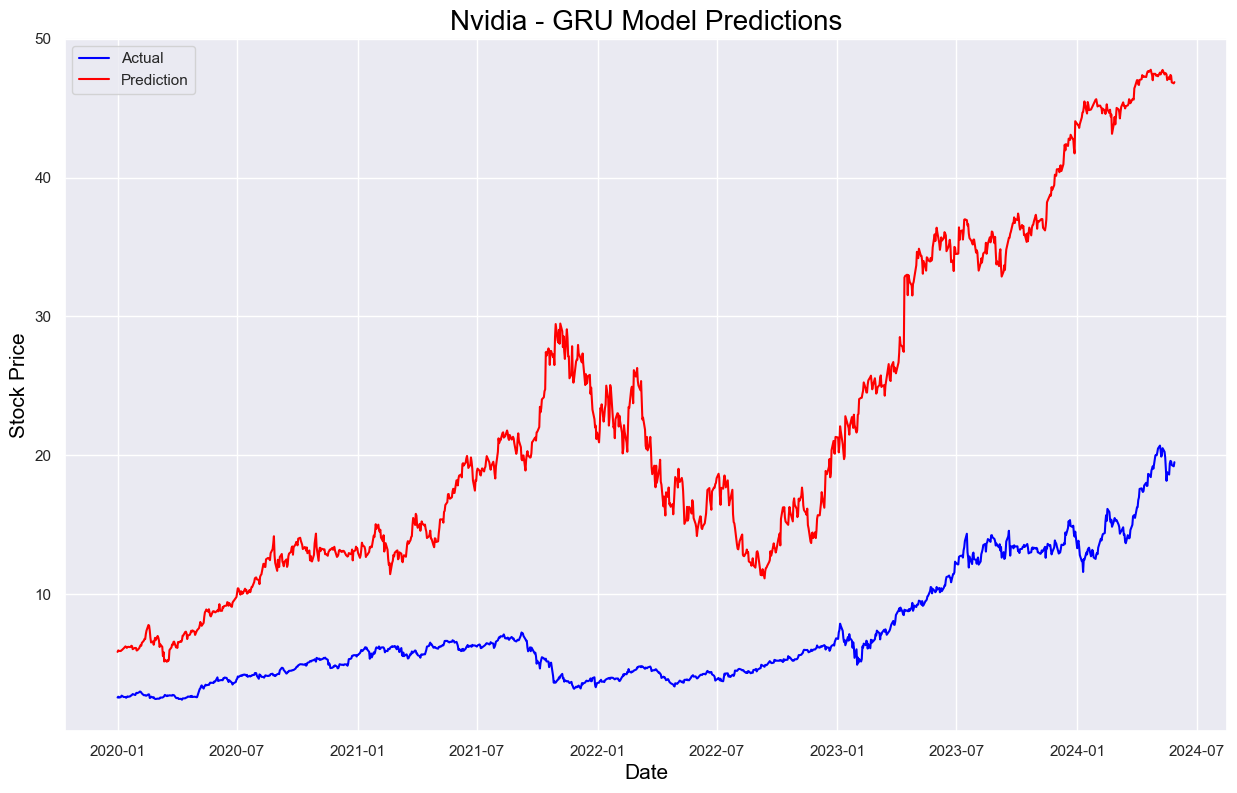

Nvidia - RNN RMSE: 6.7455
Nvidia - LSTM RMSE: 10.3410
Nvidia - GRU RMSE: 17.1355
Processing sheet: Amazon


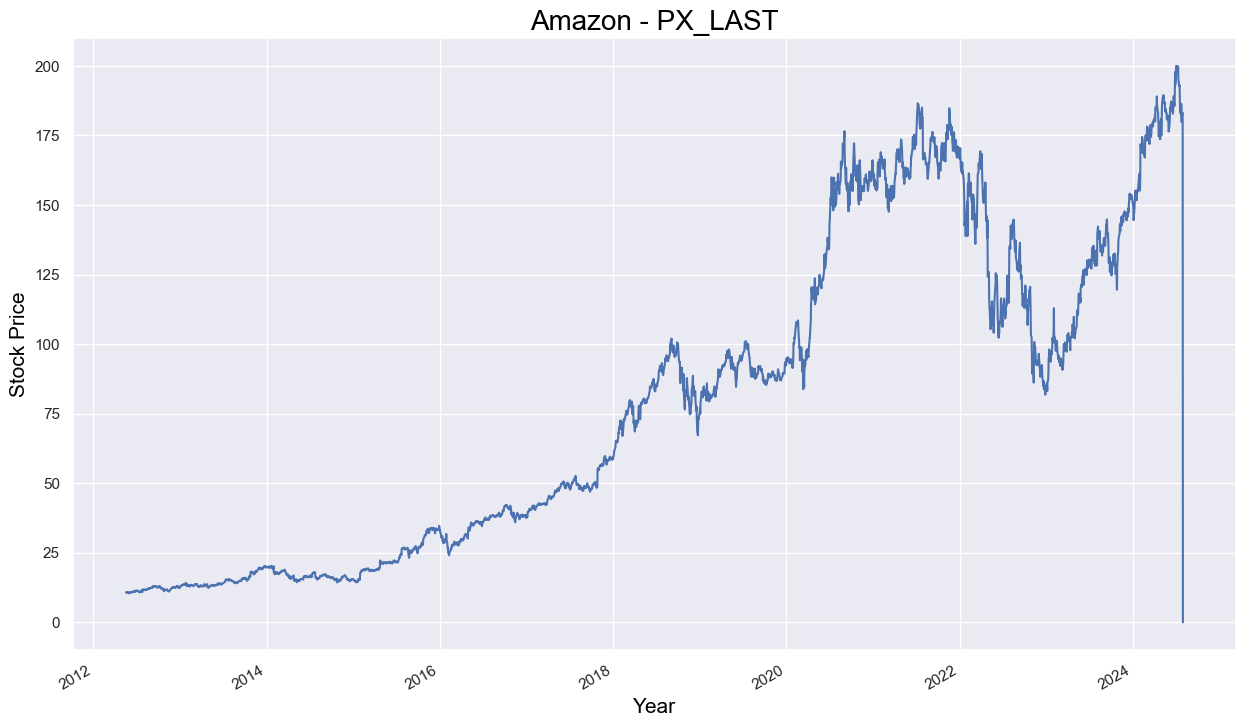

C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE score: 48.8688


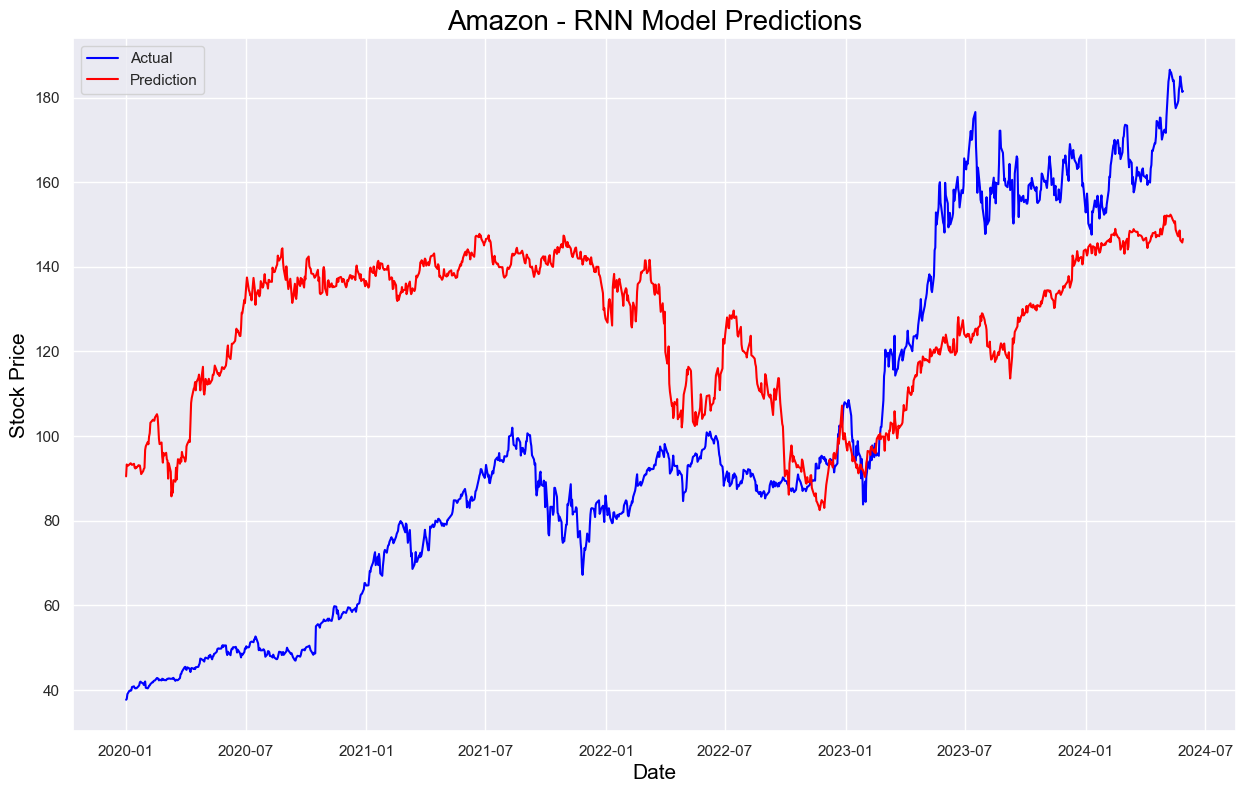

RMSE score: 54.1320


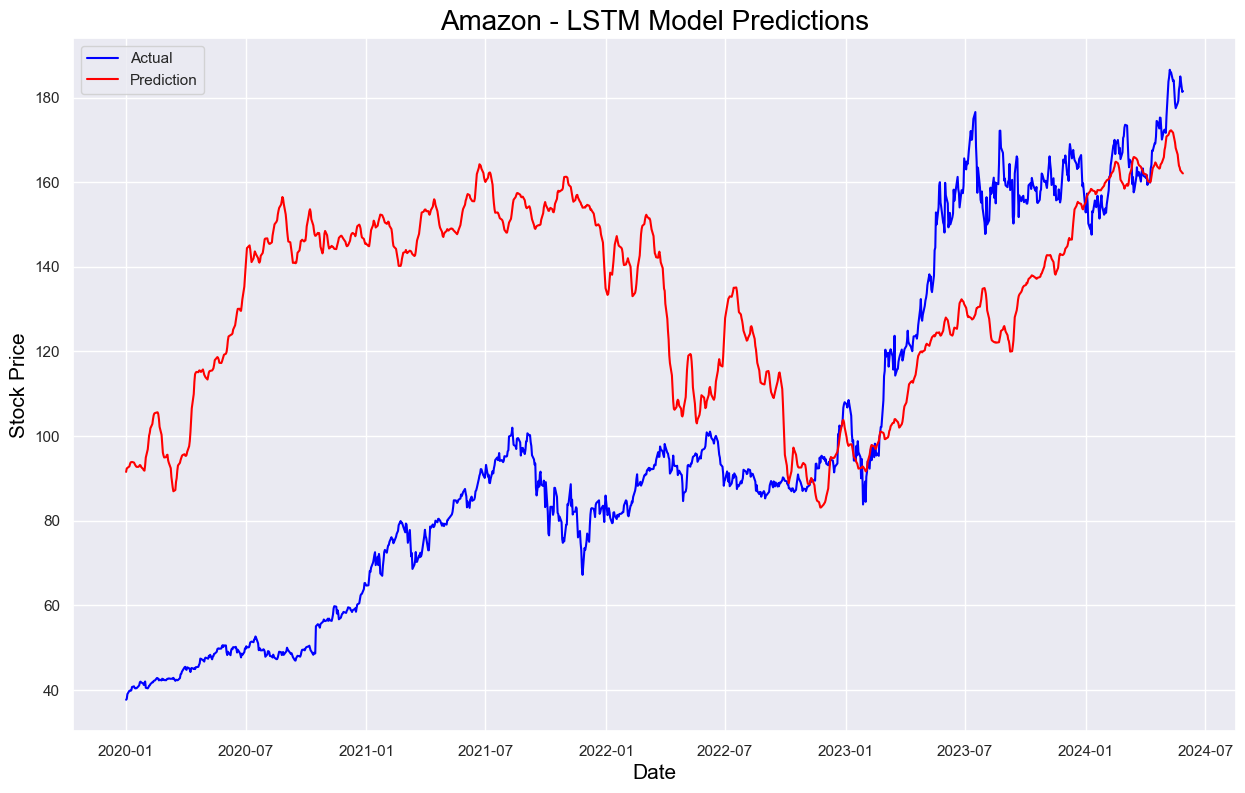

RMSE score: 58.5786


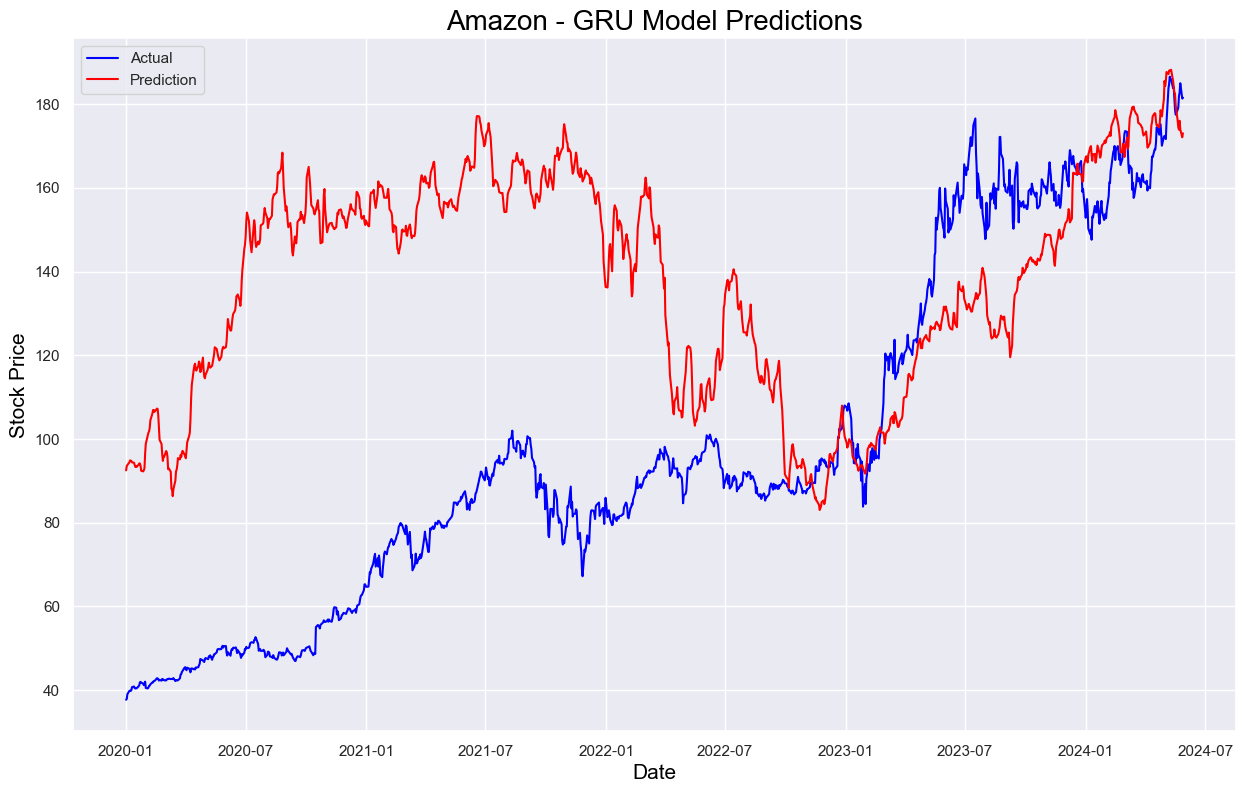

Amazon - RNN RMSE: 48.8688
Amazon - LSTM RMSE: 54.1320
Amazon - GRU RMSE: 58.5786
Processing sheet: Google


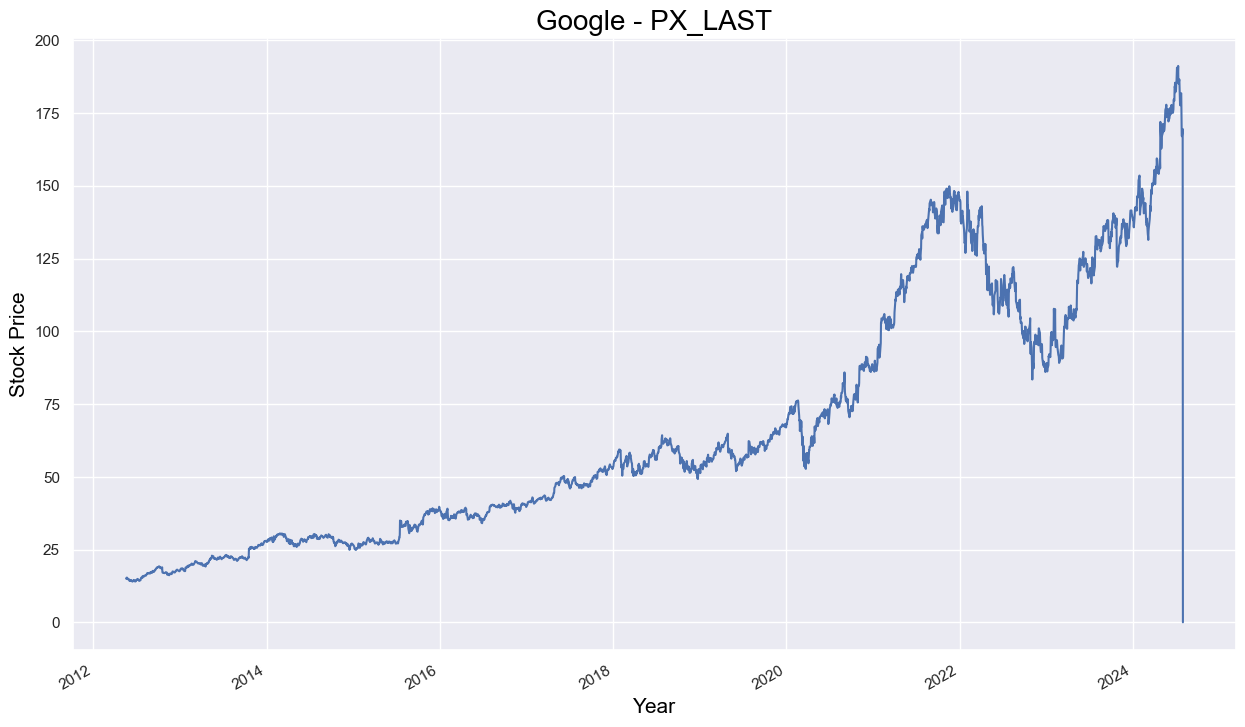

C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE score: 33.6253


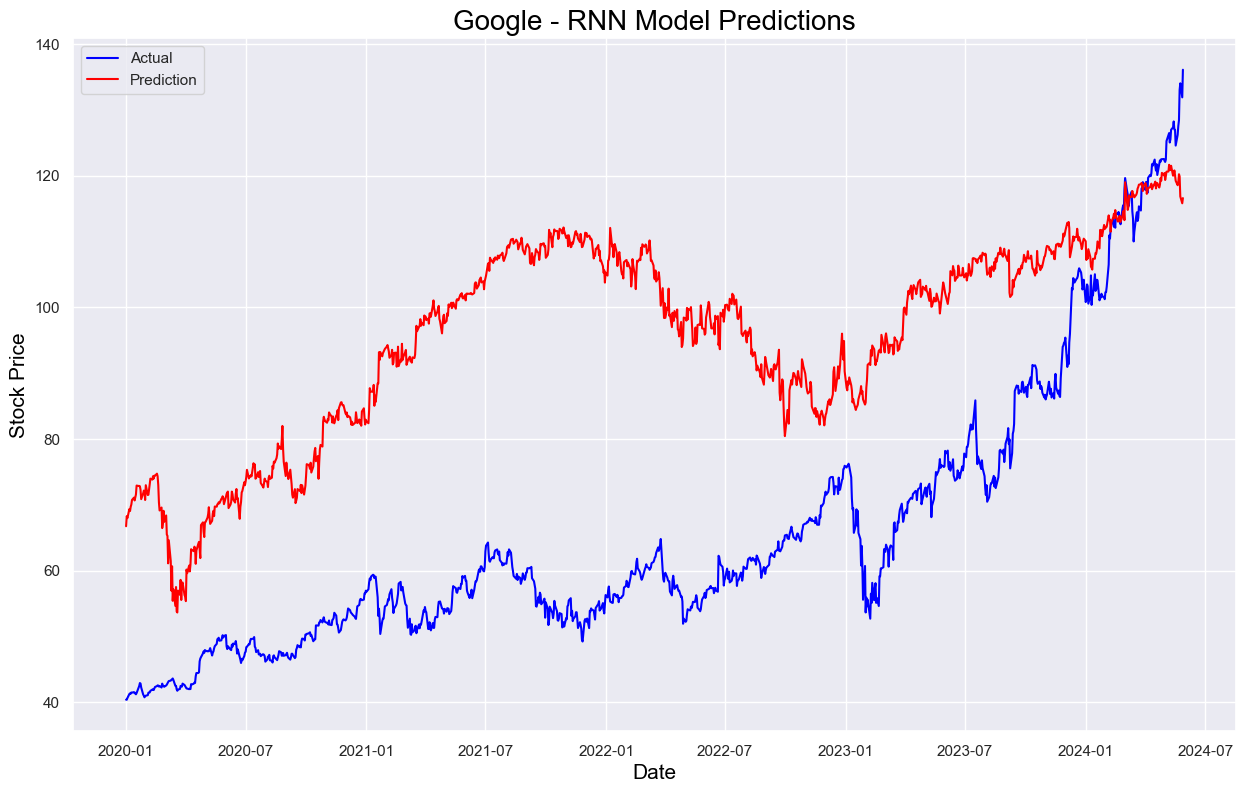

RMSE score: 42.2577


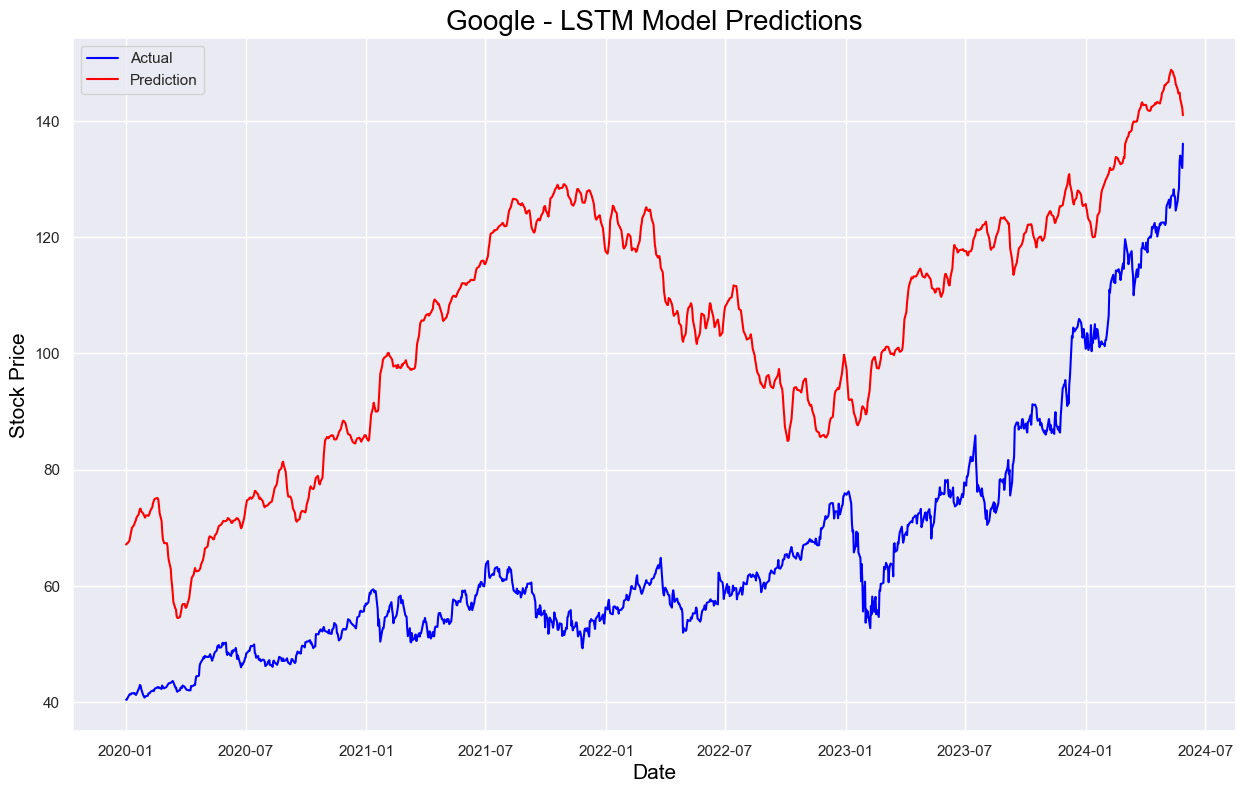

RMSE score: 47.8808


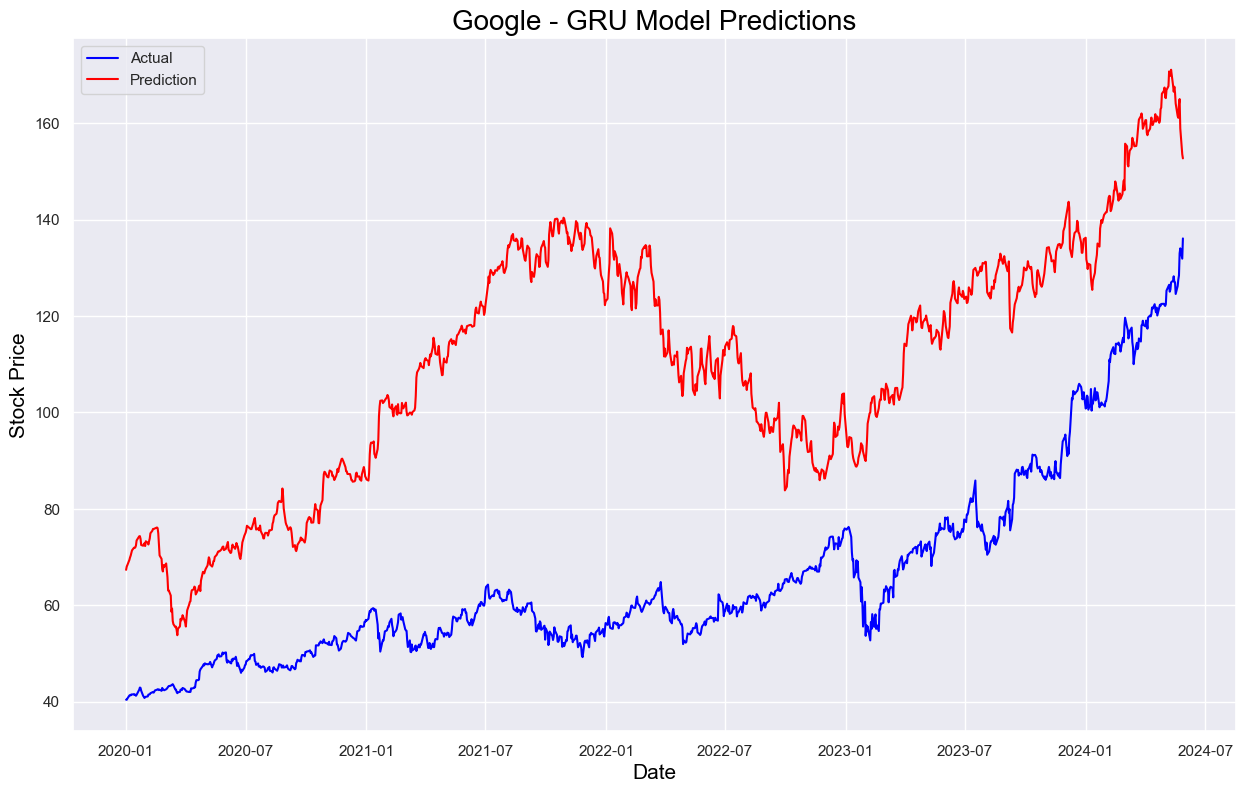

Google - RNN RMSE: 33.6253
Google - LSTM RMSE: 42.2577
Google - GRU RMSE: 47.8808
Processing sheet: Tesla


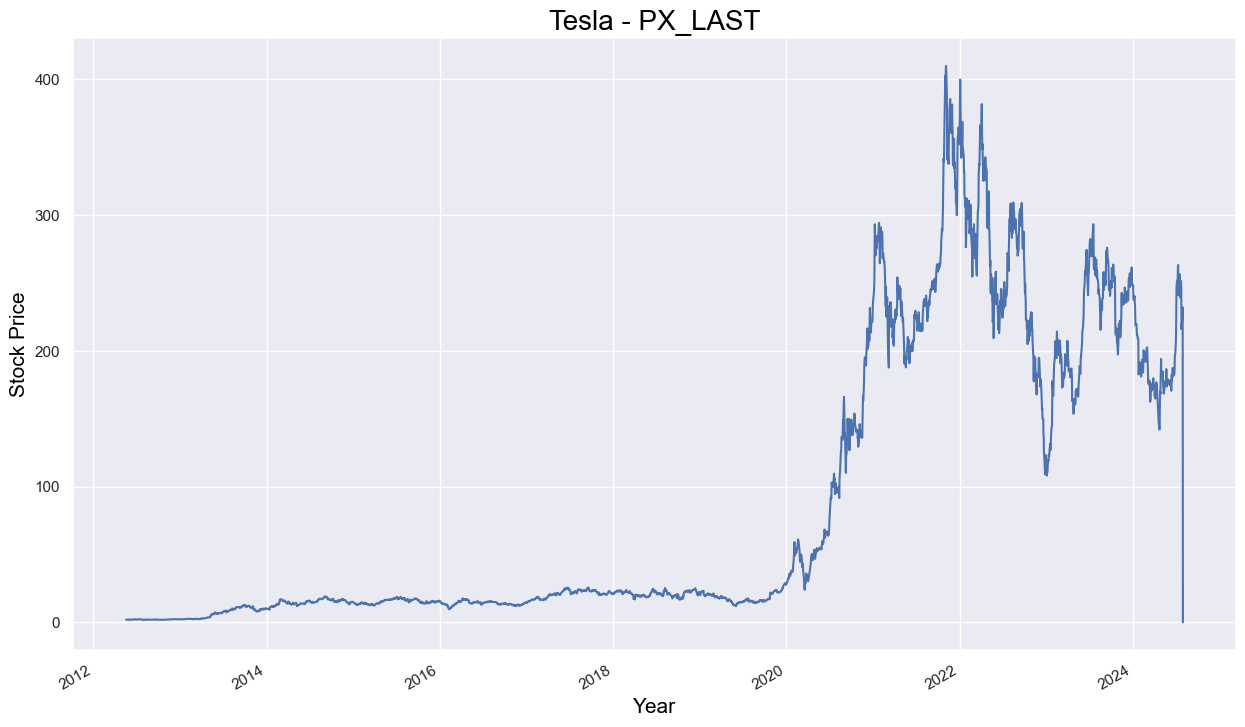

C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE score: 74.6528


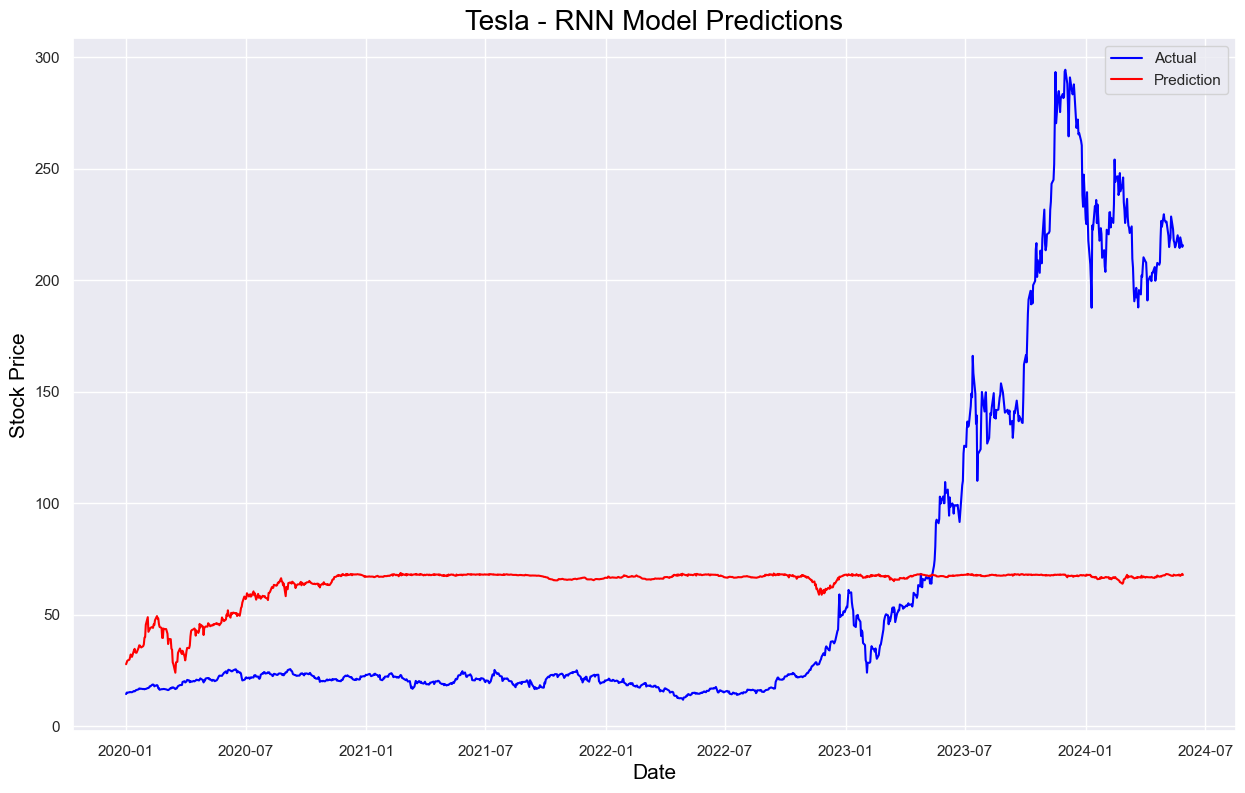

RMSE score: 105.3755


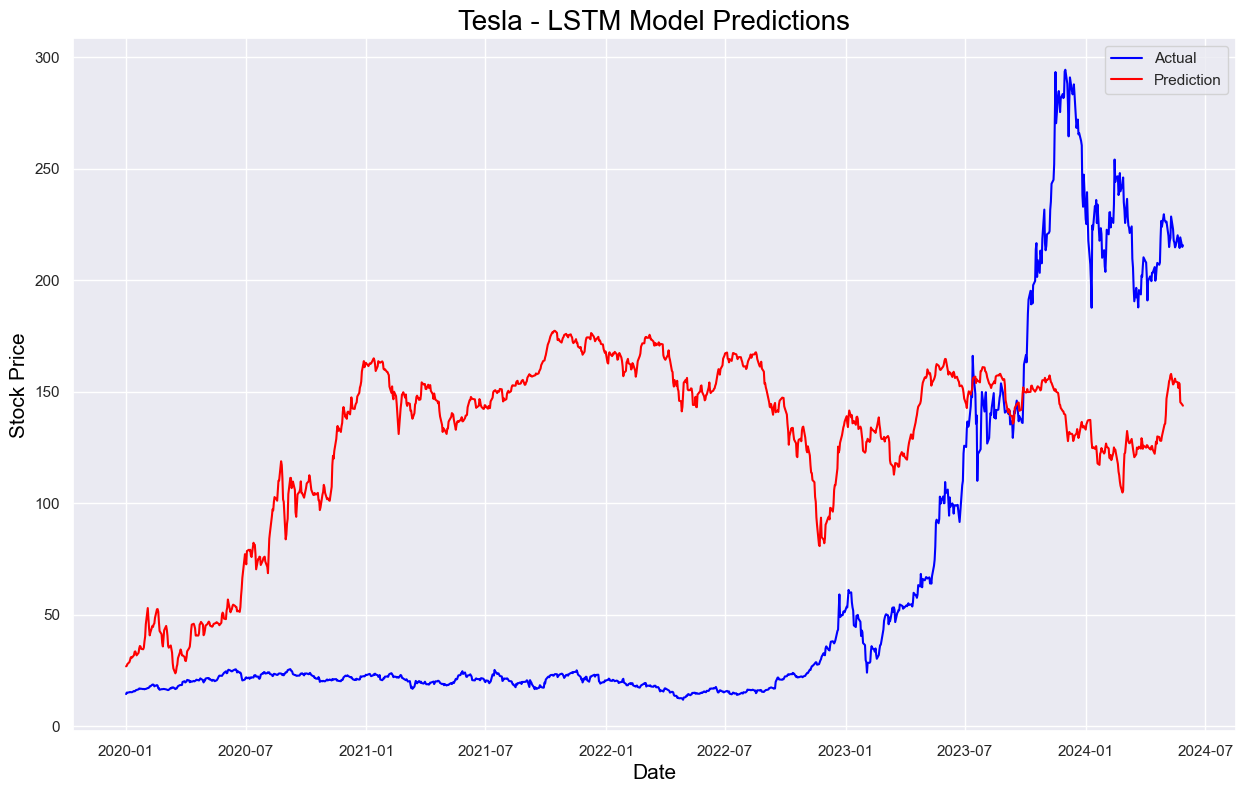

RMSE score: 117.0501


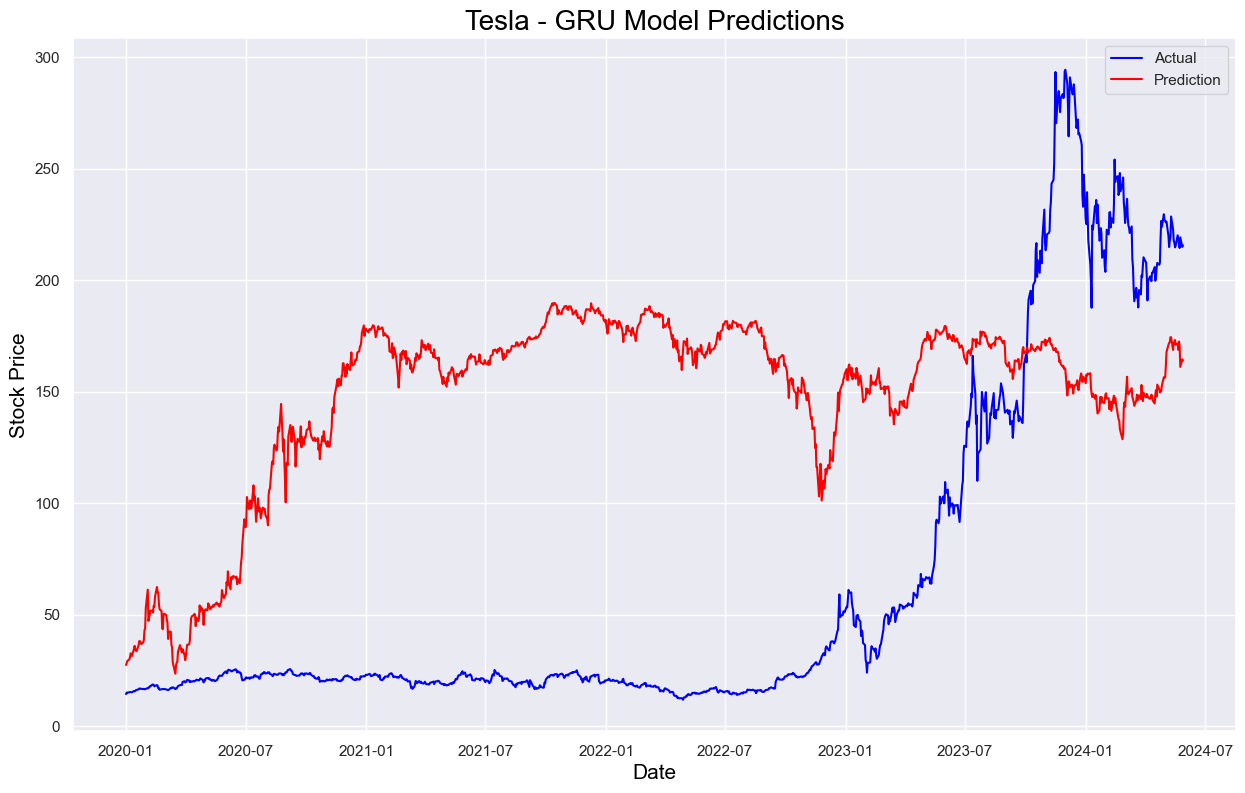

Tesla - RNN RMSE: 74.6528
Tesla - LSTM RMSE: 105.3755
Tesla - GRU RMSE: 117.0501
Processing sheet: Meta


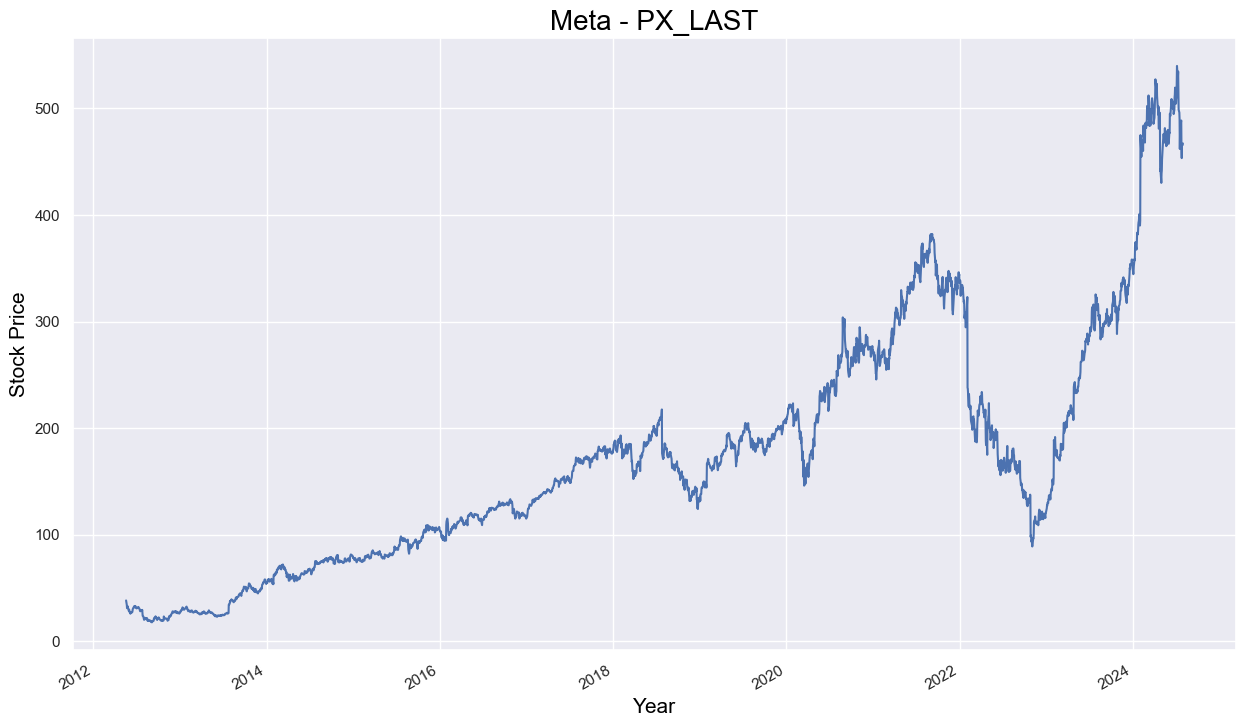

C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\bs231247\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE score: 77.7595


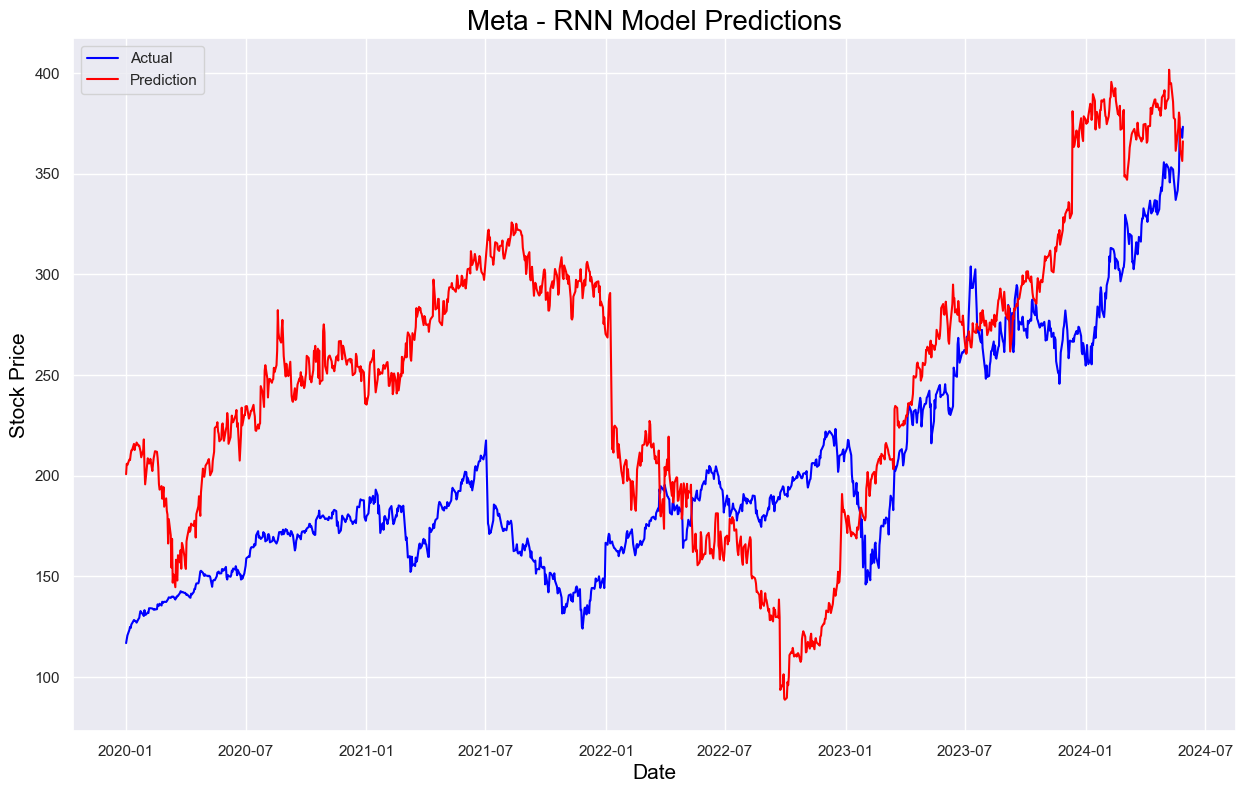

RMSE score: 87.7914


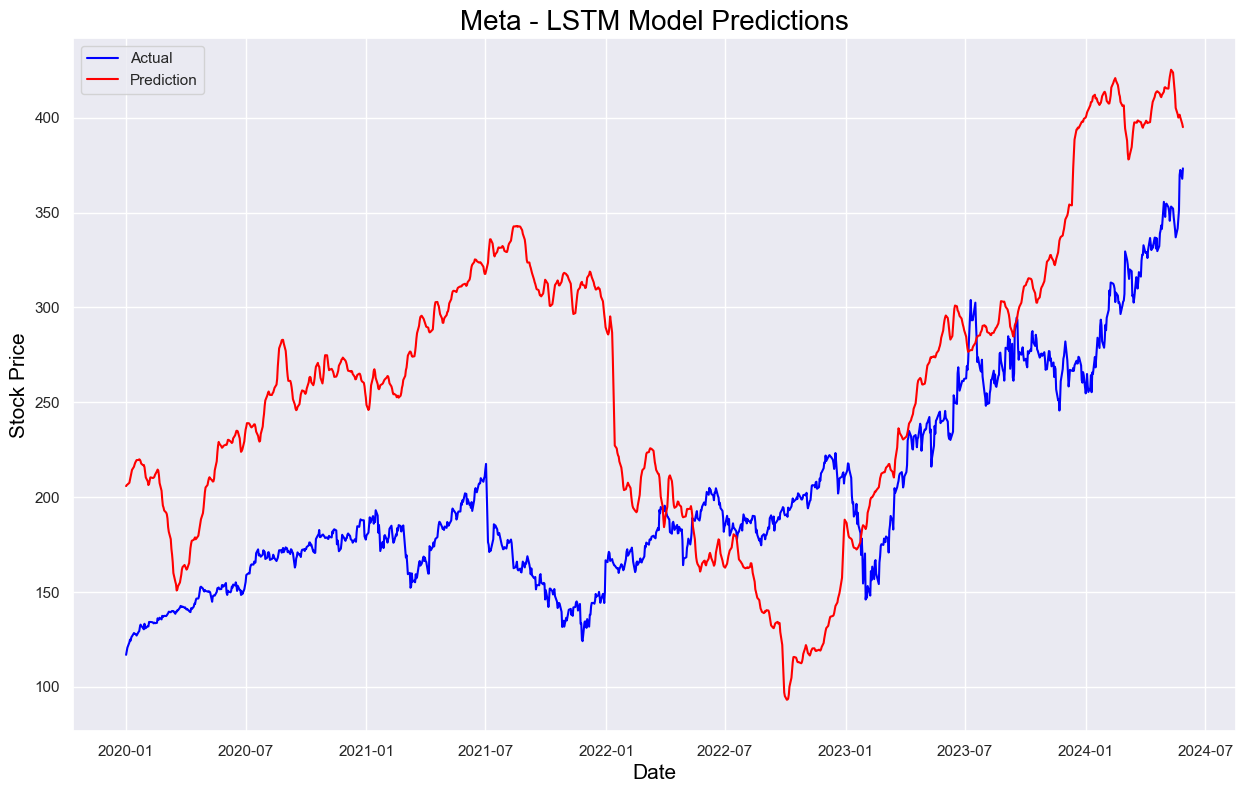

RMSE score: 101.3177


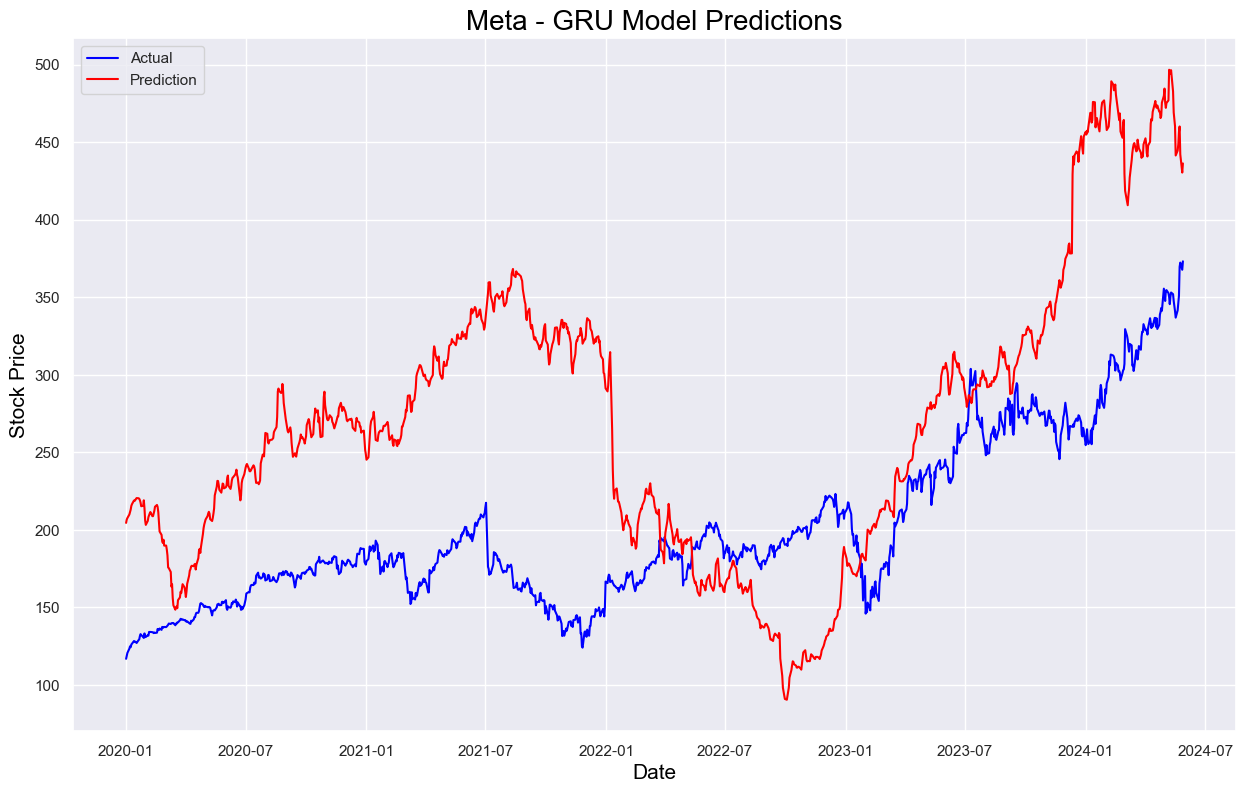

Meta - RNN RMSE: 77.7595
Meta - LSTM RMSE: 87.7914
Meta - GRU RMSE: 101.3177


In [39]:
# Iterate through each sheet and process the data
for sheet_name in excel_data.sheet_names:
    print(f"Processing sheet: {sheet_name}")
    data = excel_data.parse(sheet_name)
    process_company_data(sheet_name, data, time_steps=5, for_periods=2)